In [124]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np

%pip install tensorflow
import tensorflow as tf


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [129]:
print(tf.__version__)
print(shap.__version__)
print(np.__version__)

2.16.1
0.45.1
1.26.4


In [2]:
df_s = pd.read_csv('data/finance_stocks/finance_stocks-train.csv')
df_s.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22383 entries, 0 to 22382
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   timestamp          14363 non-null  object
 1   tweet_text         20899 non-null  object
 2   tweet_url          22383 non-null  object
 3   tweet_type         22383 non-null  object
 4   price_of_ticker    22383 non-null  object
 5   change_of_ticker   22383 non-null  object
 6   tickers_mentioned  22383 non-null  object
 7   category           22383 non-null  object
dtypes: object(8)
memory usage: 1.4+ MB


In [117]:
df_set = pd.read_csv('data/finance_stocks/finance_stocks-train.csv', nrows=20)

df_filtered = df_set[df_set['change_of_ticker'] != '[]']

# Select 10 random rows from the filtered DataFrame
df = df_filtered
#df = df_filtered.sample(n=15)

#df = df.assign(change_of_ticker=df['change_of_ticker'].str.split(',')).explode('change_of_ticker')
df['change_of_ticker'] = df['change_of_ticker'].str.extract(r'([-+]?\d+\.\d+|\d+)')
#df = df.assign(tickers_mentioned=df['tickers_mentioned'].str.split(',')).explode('tickers_mentioned')
df['tickers_mentioned'] = df['tickers_mentioned'].str.extract(r'(\$[A-Za-z]+)')

#df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.dropna()

df_filtered

timestamp  \
0   2023-11-15T09:36:42.028000+00:00   
1   2023-11-15T06:01:59.788000+00:00   
2   2023-11-15T06:01:55.590000+00:00   
3   2023-11-15T06:01:51.329000+00:00   
4   2023-11-15T04:01:49.009000+00:00   
5   2023-11-15T04:01:44.817000+00:00   
6   2023-11-15T04:01:40.263000+00:00   
7   2023-11-15T02:11:47.180000+00:00   
8   2023-11-15T02:11:41.182000+00:00   
9   2023-11-15T01:06:39.739000+00:00   
10  2023-11-14T22:46:39.669000+00:00   
11  2023-11-14T22:21:51.765000+00:00   
12  2023-11-14T22:11:51.538000+00:00   
13  2023-11-14T22:11:40.178000+00:00   
14  2023-11-14T21:51:48.390000+00:00   
15  2023-11-14T21:51:43.270000+00:00   
16  2023-11-14T20:36:43.832000+00:00   
17  2023-11-14T20:36:38.789000+00:00   
18  2023-11-14T20:31:43.687000+00:00   
19  2023-11-14T20:31:38.740000+00:00   

                                           tweet_text  \
0   $GOLD's Massive Range.\n\nIn the past ~year we...   
1   RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...   
2   RT @SmartReversals: $NDX - Daily Chart:\n\n✅Ta...   
3   RT @SmartReversals: $IWM - Daily Chart:\n\n✅Ta...   
4   RT @coiledspringcap: Everyone has been concern...   
5   RT @coiledspringcap: #SPX equal weight breakin...   
6   RT @TriggerTrades: $SPX remained above 4375 th...   
7   RT @TrendSpider: $SPY, $QQQ and $AAPL all prin...   
8   $NET \n\nWas waiting on Cloudflare and it erup...   
9   Currently at $2860--Documenting everything in ...   
10  RT @optionflys: $SPX Next update - 11 | 14 | 2...   
11  $MSFT (daily) Hanging man and new all time hig...   
12                                              $NVDA   
13  I feel like this should be pretty bullish for ...   
14  $TSLA \n\n> [@BigCheds](https://twitter.com/Bi...   
15                          Burry is that you?  $SOXX   
16                 $TSLA\n\nI love those W patterns..   
17                         $FG \n\nAnother strong day   
18  TSLA flow was spot on\n\n> [@CheddarFlow](http...   
19  $SNAP\n\nGetting really close to breaking out ...   

                                            tweet_url   tweet_type  \
0   https://twitter.com/user/status/17247221551437...        tweet   
1   https://twitter.com/user/status/17246687922221...      retweet   
2   https://twitter.com/user/status/17246687824535...      retweet   
3   https://twitter.com/user/status/17246687591081...      retweet   
4   https://twitter.com/user/status/17246376898767...      retweet   
5   https://twitter.com/user/status/17246376783927...      retweet   
6   https://twitter.com/user/status/17246376379723...      retweet   
7   https://twitter.com/user/status/17246108137746...      retweet   
8   https://twitter.com/user/status/17246106454321...        tweet   
9   https://twitter.com/user/status/17245942794969...  quote tweet   
10  https://twitter.com/user/status/17245590075775...      retweet   
11  https://twitter.com/user/status/17245531331566...        tweet   
12  https://twitter.com/user/status/17245503670676...        tweet   
13  https://twitter.com/user/status/17245497377837...  quote tweet   
14  https://twitter.com/user/status/17245455132387...  quote tweet   
15  https://twitter.com/user/status/17245453184888...        tweet   
16  https://twitter.com/user/status/17245258276546...        tweet   
17  https://twitter.com/user/status/17245256079276...        tweet   
18  https://twitter.com/user/status/17245245043896...  quote tweet   
19  https://twitter.com/user/status/17245245026866...        tweet   

                    price_of_ticker change_of_ticker tickers_mentioned  \
0                         ['15.71']            +3.69             $GOLD   
1                       ['4495.71']            +1.87              $SPX   
2                     ['15812.473']            +2.08              $NDX   
3                        ['178.46']            +5.21              $IWM   
4                       ['4495.71']            +1.87              $SPX   
5                       ['4495.71']            +1.87              $SPX   

In [14]:
new_rows = []
for index, row in df.iterrows():
    values1 = row['change_of_ticker'].split(',')
    values2 = row['tickers_mentioned'].split(',')
    for i in range(len(values1)):
        new_row = row.copy()  
        new_row['change_of_ticker'] = values1[i] 
        new_row['tickers_mentioned'] = values2[i]  
        new_rows.append(new_row)  

new_df = pd.DataFrame(new_rows)

new_df

timestamp  \
0    2023-11-15T09:36:42.028000+00:00   
1    2023-11-15T06:01:59.788000+00:00   
2    2023-11-15T06:01:55.590000+00:00   
3    2023-11-15T06:01:51.329000+00:00   
4    2023-11-15T04:01:49.009000+00:00   
..                                ...   
595  2023-08-16T21:47:40.068000+00:00   
596  2023-08-16T20:52:56.463000+00:00   
597  2023-08-16T20:52:51.472000+00:00   
598  2023-08-16T20:52:44.538000+00:00   
599  2023-08-16T20:37:44.290000+00:00   

                                            tweet_text  \
0    $GOLD's Massive Range.\n\nIn the past ~year we...   
1    RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...   
2    RT @SmartReversals: $NDX - Daily Chart:\n\n✅Ta...   
3    RT @SmartReversals: $IWM - Daily Chart:\n\n✅Ta...   
4    RT @coiledspringcap: Everyone has been concern...   
..                                                 ...   
595  $COIN #coinbase (daily) False breakout reversa...   
596  RT @CyclesFan: $SPX - Broke below the trendlin...   
597  RT @cfromhertz: $QQQ #QQQ \n\nDaily VPOC gone,...   
598  RT @cfromhertz: $ARKK Growth at any cost \n\n-...   
599  Get back above ~15300 and the 50d MA and I am ...   

                                             tweet_url tweet_type  \
0    https://twitter.com/user/status/17247221551437...      tweet   
1    https://twitter.com/user/status/17246687922221...    retweet   
2    https://twitter.com/user/status/17246687824535...    retweet   
3    https://twitter.com/user/status/17246687591081...    retweet   
4    https://twitter.com/user/status/17246376898767...    retweet   
..                                                 ...        ...   
595  https://twitter.com/user/status/16919290591549...      tweet   
596  https://twitter.com/user/status/16919155590411...    retweet   
597  https://twitter.com/user/status/16919153668875...    retweet   
598  https://twitter.com/user/status/16919153105370...    retweet   
599  https://twitter.com/user/status/16919110109473...      tweet   

              price_of_ticker change_of_ticker tickers_mentioned      category  
0                   ['15.71']            +3.69             $GOLD  stock_images  
1                 ['4495.71']            +1.87              $SPX  stock_images  
2               ['15812.473']            +2.08              $NDX  stock_images  
3                  ['178.46']            +5.21              $IWM  stock_images  
4                 ['4495.71']            +1.87              $SPX  stock_images  
..                        ...              ...               ...           ...  
595                  ['79.0']            -0.23             $COIN  stock_images  
596               ['4404.32']            -0.76              $SPX  stock_images  
597                ['362.54']            -1.07              $QQQ  stock_images  
598                 ['41.24']            -2.26             $ARKK  stock_images  
599  ['362.54', '14876.4695']            -1.07              $QQQ  stock_images  

[598 rows x 8 columns]

In [48]:
tickers_of_interest = ['$SPX', '$COIN', '$QQQ']
filtered_df_plot = df[df['tickers_mentioned'].isin(tickers_of_interest)]
filtered_df_plot

timestamp  \
1    2023-11-15T06:01:59.788000+00:00   
4    2023-11-15T04:01:49.009000+00:00   
5    2023-11-15T04:01:44.817000+00:00   
6    2023-11-15T04:01:40.263000+00:00   
7    2023-11-15T02:11:47.180000+00:00   
..                                ...   
588  2023-08-17T15:27:52.126000+00:00   
595  2023-08-16T21:47:40.068000+00:00   
596  2023-08-16T20:52:56.463000+00:00   
597  2023-08-16T20:52:51.472000+00:00   
599  2023-08-16T20:37:44.290000+00:00   

                                            tweet_text  \
1    RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...   
4    RT @coiledspringcap: Everyone has been concern...   
5    RT @coiledspringcap: #SPX equal weight breakin...   
6    RT @TriggerTrades: $SPX remained above 4375 th...   
7    RT @TrendSpider: $SPY, $QQQ and $AAPL all prin...   
..                                                 ...   
588  $QQQ\n\nGetting into dangerous territory, need...   
595  $COIN #coinbase (daily) False breakout reversa...   
596  RT @CyclesFan: $SPX - Broke below the trendlin...   
597  RT @cfromhertz: $QQQ #QQQ \n\nDaily VPOC gone,...   
599  Get back above ~15300 and the 50d MA and I am ...   

                                             tweet_url tweet_type  \
1    https://twitter.com/user/status/17246687922221...    retweet   
4    https://twitter.com/user/status/17246376898767...    retweet   
5    https://twitter.com/user/status/17246376783927...    retweet   
6    https://twitter.com/user/status/17246376379723...    retweet   
7    https://twitter.com/user/status/17246108137746...    retweet   
..                                                 ...        ...   
588  https://twitter.com/user/status/16921964540335...      tweet   
595  https://twitter.com/user/status/16919290591549...      tweet   
596  https://twitter.com/user/status/16919155590411...    retweet   
597  https://twitter.com/user/status/16919153668875...    retweet   
599  https://twitter.com/user/status/16919110109473...      tweet   

                    price_of_ticker change_of_ticker tickers_mentioned  \
1                       ['4495.71']            +1.87              $SPX   
4                       ['4495.71']            +1.87              $SPX   
5                       ['4495.71']            +1.87              $SPX   
6                       ['4495.71']            +1.87              $SPX   
7    ['385.33', '187.44', '448.73']            +2.11              $QQQ   
..                              ...              ...               ...   
588                      ['360.99']            -0.43              $QQQ   
595                        ['79.0']            -0.23             $COIN   
596                     ['4404.32']            -0.76              $SPX   
597                      ['362.54']            -1.07              $QQQ   
599        ['362.54', '14876.4695']            -1.07              $QQQ   

         category  
1    stock_images  
4    stock_images  
5    stock_images  
6    stock_images  
7    stock_images  
..            ...  
588  stock_images  
595  stock_images  
596  stock_images  
597  stock_images  
599  stock_images  

[98 rows x 8 columns]

In [ ]:
filtered_df_plot['change_of_ticker'] = filtered_df_plot['change_of_ticker'].str.replace('+', '').astype(float)

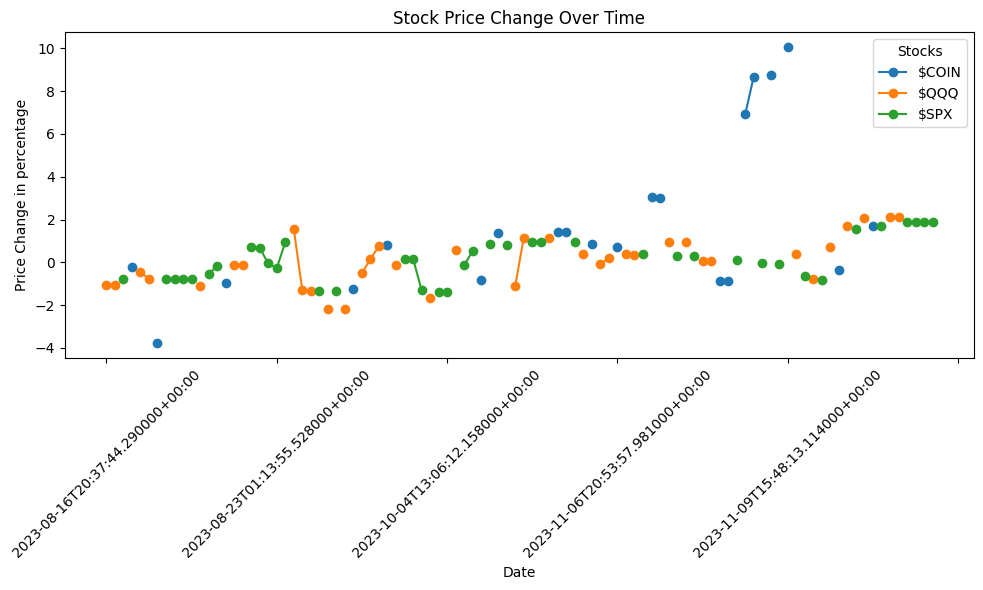

In [68]:

pivot_df = filtered_df_plot.pivot(index='timestamp', columns='tickers_mentioned', values='change_of_ticker')

# Plot the data
pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Stock Price Change Over Time')
plt.xlabel('Date')
plt.ylabel('Price Change in percentage')
plt.legend(title='Stocks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 Simple LSTM (Long Short-Term Memory) model for predicting stock prices

In [72]:
new_df.head()


timestamp  \
0  2023-11-15T09:36:42.028000+00:00   
1  2023-11-15T06:01:59.788000+00:00   
2  2023-11-15T06:01:55.590000+00:00   
3  2023-11-15T06:01:51.329000+00:00   
4  2023-11-15T04:01:49.009000+00:00   

                                          tweet_text  \
0  $GOLD's Massive Range.\n\nIn the past ~year we...   
1  RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...   
2  RT @SmartReversals: $NDX - Daily Chart:\n\n✅Ta...   
3  RT @SmartReversals: $IWM - Daily Chart:\n\n✅Ta...   
4  RT @coiledspringcap: Everyone has been concern...   

                                           tweet_url tweet_type  \
0  https://twitter.com/user/status/17247221551437...      tweet   
1  https://twitter.com/user/status/17246687922221...    retweet   
2  https://twitter.com/user/status/17246687824535...    retweet   
3  https://twitter.com/user/status/17246687591081...    retweet   
4  https://twitter.com/user/status/17246376898767...    retweet   

  price_of_ticker change_of_ticker tickers_mentioned      category  
0       ['15.71']            +3.69             $GOLD  stock_images  
1     ['4495.71']            +1.87              $SPX  stock_images  
2   ['15812.473']            +2.08              $NDX  stock_images  
3      ['178.46']            +5.21              $IWM  stock_images  
4     ['4495.71']            +1.87              $SPX  stock_images

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [94]:
df_pred = new_df[['timestamp', 'tweet_text', 'tweet_type', 'tickers_mentioned','change_of_ticker']]
df_pred.head()

timestamp  \
0  2023-11-15T09:36:42.028000+00:00   
1  2023-11-15T06:01:59.788000+00:00   
2  2023-11-15T06:01:55.590000+00:00   
3  2023-11-15T06:01:51.329000+00:00   
4  2023-11-15T04:01:49.009000+00:00   

                                          tweet_text tweet_type  \
0  $GOLD's Massive Range.\n\nIn the past ~year we...      tweet   
1  RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...    retweet   
2  RT @SmartReversals: $NDX - Daily Chart:\n\n✅Ta...    retweet   
3  RT @SmartReversals: $IWM - Daily Chart:\n\n✅Ta...    retweet   
4  RT @coiledspringcap: Everyone has been concern...    retweet   

  tickers_mentioned change_of_ticker  
0             $GOLD            +3.69  
1              $SPX            +1.87  
2              $NDX            +2.08  
3              $IWM            +5.21  
4              $SPX            +1.87

In [111]:
X = df_pred[['timestamp', 'tweet_text', 'tweet_type','tickers_mentioned']]
y = df_pred['change_of_ticker']

In [112]:
X = pd.get_dummies(X)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [107]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [108]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)


Mean Absolute Error: 2.1615100000000003


In [114]:
from transformers import pipeline

In [115]:
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")


In [118]:
predictions = [pipe(text)[0]['label'] for text in df["tweet_text"]]
df['Sentiment'] = predictions

In [119]:
shap_df = df[['tweet_text', 'Sentiment', 'change_of_ticker']]
shap_df

tweet_text Sentiment  \
0   $GOLD's Massive Range.\n\nIn the past ~year we...  positive   
1   RT @SmartReversals: $SPX - Daily Chart:\n\n✅Ta...   neutral   
2   RT @SmartReversals: $NDX - Daily Chart:\n\n✅Ta...   neutral   
3   RT @SmartReversals: $IWM - Daily Chart:\n\n✅Ta...   neutral   
4   RT @coiledspringcap: Everyone has been concern...  negative   
5   RT @coiledspringcap: #SPX equal weight breakin...  positive   
6   RT @TriggerTrades: $SPX remained above 4375 th...  positive   
7   RT @TrendSpider: $SPY, $QQQ and $AAPL all prin...   neutral   
8   $NET \n\nWas waiting on Cloudflare and it erup...   neutral   
9   Currently at $2860--Documenting everything in ...   neutral   
10  RT @optionflys: $SPX Next update - 11 | 14 | 2...   neutral   
11  $MSFT (daily) Hanging man and new all time hig...   neutral   
12                                              $NVDA   neutral   
13  I feel like this should be pretty bullish for ...  positive   
14  $TSLA \n\n> [@BigCheds](https://twitter.com/Bi...   neutral   
15                          Burry is that you?  $SOXX   neutral   
16                 $TSLA\n\nI love those W patterns..   neutral   
17                         $FG \n\nAnother strong day  positive   
18  TSLA flow was spot on\n\n> [@CheddarFlow](http...   neutral   
19  $SNAP\n\nGetting really close to breaking out ...   neutral   

   change_of_ticker  
0             +3.69  
1             +1.87  
2             +2.08  
3             +5.21  
4             +1.87  
5             +1.87  
6             +1.87  
7             +2.11  
8             +9.52  
9             +6.85  
10            +2.11  
11            +0.97  
12            +2.09  
13            +0.97  
14            +5.77  
15            +3.57  
16            +5.75  
17            +6.86  
18            +5.82  
19            +6.15

In [ ]:
df

timestamp  \
19299                               NaN   
14775                               NaN   
6061   2022-09-12T14:21:28.097000+00:00   
9034   2022-06-03T00:11:10.364000+00:00   
14796                               NaN   
11286                               NaN   
7930   2022-07-11T17:28:24.137000+00:00   
7878   2022-07-13T12:50:09.876000+00:00   
1816   2023-05-23T13:58:54.604000+00:00   
18969  2022-06-02T18:21:54.564000+00:00   
5023   2022-11-30T20:13:54.026000+00:00   
11116                               NaN   
7262   2022-08-03T15:13:56.064000+00:00   
4322   2023-01-10T03:36:12.398000+00:00   
3478   2023-02-10T14:45:26.616000+00:00   

                                              tweet_text  \
19299                                       $TWTR HALT 👀   
14775  $QQQ\n\nNasdaq may find some support here a bi...   
6061                          $SNOW REPEAT SWEEPER  ❄️❄️   
9034   $AUY $AGI $AG $EGO I think all of the miners I...   
14796  $XPEV\n\nDaily triangle setup--China names hav...   
11286     $SQ #SQ give us $105? 🤑\n\nTarget $120 // $134   
7930   silver miners out to 7 year relative lows...\n...   
7878   $LULU Still in the range, but it looks like it...   
1816   $TEAM higher low on the daily above the 50sma ...   
18969  Little flag forming on $SPX daily. Let’s see w...   
5023   $SPX Testing the Daily 200MA (Purple).\n\nThe ...   
11116                                                $ES   
7262                  $LTRY .72 MFERS — ALMOST 100% here   
4322   $SPX Next update : 01/09/2023 - After Close. \...   
3478   It's happening ! $spy\n\nWith a 1h cloud break...   

                                               tweet_url tweet_type  \
19299  https://twitter.com/Ultra_Calls/status/1518661...      tweet   
14775  https://twitter.com/ShardiB2/status/1483448112...      tweet   
6061   https://twitter.com/ThetaWarrior/status/156933...      tweet   
9034   https://twitter.com/HackermanAce/status/153251...      tweet   
14796  https://twitter.com/Albert_trades/status/14832...      tweet   
11286  https://twitter.com/_bread911/status/151369398...      tweet   
7930   https://twitter.com/the_chart_life/status/1546...      tweet   
7878   https://twitter.com/Amdtrades/status/154720169...      tweet   
1816   https://twitter.com/rachels_44/status/16610087...      tweet   
18969  https://twitter.com/rachels_44/status/15324272...      tweet   
5023   https://twitter.com/DaanCrypto/status/15980476...      tweet   
11116  https://twitter.com/StonkTrump/status/15145850...      tweet   
7262   https://twitter.com/Ultra_Calls/status/1554848...      tweet   
4322   https://twitter.com/reciknows/status/161265448...      tweet   
3478   https://twitter.com/HackermanAce/status/162405...      tweet   

       price_of_ticker  change_of_ticker                tickers_mentioned  \
19299              NaN               NaN                        ['$TWTR']   
14775              NaN               NaN                         ['$QQQ']   
6061               NaN               NaN                        ['$SNOW']   
9034               NaN               NaN  ['$EGO', '$AG', '$AGI', '$AUY']   
14796              NaN               NaN                        ['$XPEV']   
11286              NaN               NaN                          ['$SQ']   
7930               NaN               NaN                         ['$SIL']   
7878               NaN               NaN                        ['$LULU']   
1816               NaN               NaN                        ['$TEAM']   
18969              NaN               NaN                         ['$SPX']   
5023               NaN               NaN                         ['$SPX']   
11116              NaN               NaN                        ['$ES=F']   
7262               NaN               NaN                        ['$LTRY']   
4322               NaN               NaN         ['$QQQ', '$SPX', '$SPY']   
3478               NaN               NaN                         ['$SPY']   

          

In [130]:
explainer = shap.Explainer(pipe)
shap_values = explainer(shap_df["tweet_text"])

PartitionExplainer explainer:   5%|▌         | 1/20 [00:00<?, ?it/s]




PartitionExplainer explainer:  15%|█▌        | 3/20 [00:25<01:36,  5.70s/it]




PartitionExplainer explainer:  20%|██        | 4/20 [00:36<02:07,  7.94s/it]



PartitionExplainer explainer:  25%|██▌       | 5/20 [00:47<02:16,  9.08s/it]



PartitionExplainer explainer:  30%|███       | 6/20 [02:33<09:57, 42.68s/it]




PartitionExplainer explainer:  35%|███▌      | 7/20 [02:44<06:57, 32.15s/it]



PartitionExplainer explainer:  40%|████      | 8/20 [02:55<05:03, 25.30s/it]



PartitionExplainer explainer:  45%|████▌     | 9/20 [03:05<03:46, 20.57s/it]


PartitionExplainer explainer:  50%|█████     | 10/20 [03:15<02:51, 17.14s/it]









































PartitionExplainer explainer:  55%|█████▌    | 11/20 [03:34<02:40, 17.79s/it]



PartitionExplainer explainer:  60%|██████    | 12/20 [03:44<02:02, 15.29s/it]


PartitionExplainer explainer:  70%|███████   | 14/20 [03:49<00:52,  8.69s/it]










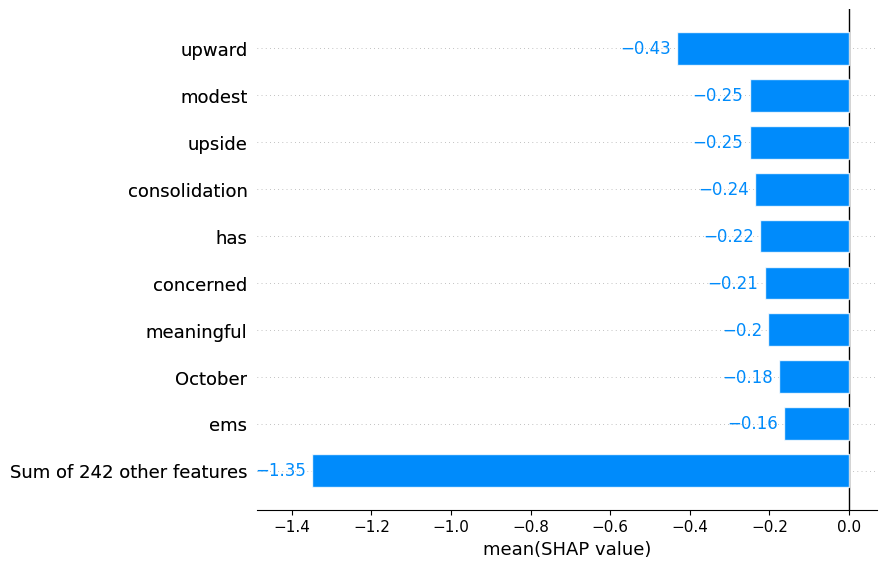

In [ ]:
shap.plots.bar(shap_values[:, :, "neutral"].mean(0), order=shap.Explanation.argsort)


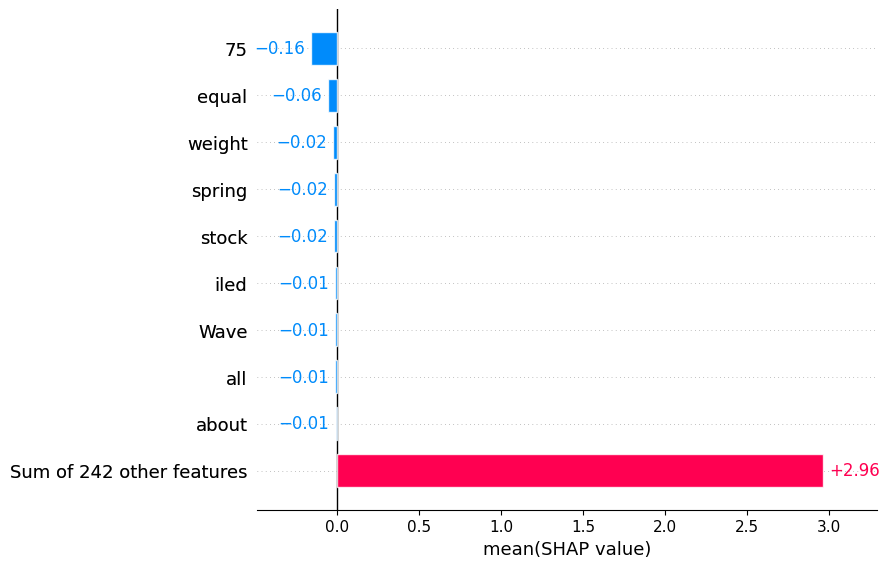

In [ ]:
shap.plots.bar(shap_values[:, :, "positive"].mean(0), order=shap.Explanation.argsort)

In [ ]:
shap.plots.text(shap_values[:, :, "positive"])

In [ ]:
shap.plots.text(shap_values)